In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib widget
basePath ='./sims.TNG/TNG50-1/output'
from tqdm import tqdm
import gc

fields=['SubhaloPos','SubhaloMass']

In [2]:
class Cell:
    def __init__(self):
        self.Coordinate = [0, 0]
        self.Mass = 0
        self.Temperature = 0

class Cloud:
    def __init__(self, x_range, y_range):
        x_min, x_max = x_range
        y_min, y_max = y_range
        x_centers = np.arange(x_min + 0.25, x_max, 0.5)
        y_centers = np.arange(y_min + 0.25, y_max, 0.5)
        xx, yy = np.meshgrid(x_centers, y_centers)
        self.cells = [Cell() for _ in range(xx.size)]
        self.x_range = x_range
        self.y_range = y_range
        self.assign_coordinates(xx.flatten(), yy.flatten())

    def assign_coordinates(self, x_coords, y_coords):
        for i, cell in enumerate(self.cells):
            cell.Coordinate = np.array([ y_coords[i], x_coords[i]])

    def assign_parameter(self, coordinates: np.ndarray,masses: np.ndarray, temperature: np.ndarray):
        x_min, x_max = self.x_range
        y_min, y_max = self.y_range
        x_bars = int((x_max - x_min) / 0.5)
        for i in range(coordinates.shape[0]):
            coord = coordinates[i]
            param = temperature[i]
            mass=masses[i]
            x_index = int((coord[1] - x_min) / 0.5)
            y_index = int((coord[2] - y_min) / 0.5)
            if x_index >= x_bars or y_index >= x_bars or x_index<0 or y_index < 0:
                continue
            if param > 10000:
                continue
            index = x_index * x_bars + y_index
            self.cells[index].Temperature = param
            self.cells[index].Mass += mass

            
    def assign_mass(self, coordinates: np.ndarray,masses: np.ndarray):
        x_min, x_max = self.x_range
        y_min, y_max = self.y_range
        x_bars = int((x_max - x_min) / 0.5)
        for i in range(coordinates.shape[0]):
            coord = coordinates[i]
            mass=masses[i]
            x_index = int((coord[0] - x_min) / 0.5)
            y_index = int((coord[2] - y_min) / 0.5)
            if x_index >= x_bars or y_index >= x_bars or x_index<0 or y_index < 0:
                continue
            index = x_index * x_bars + y_index
            self.cells[index].Mass += mass    
    
    
    
    def visualize(self, savePath):
        plt.figure(figsize=(20, 20), dpi=300)
        plt.style.use("dark_background")
        x_range, y_range = self.x_range, self.y_range
        plt.hist2d([cell.Coordinate[0] for cell in self.cells], [cell.Coordinate[1] for cell in self.cells], norm=mpl.colors.LogNorm(),cmin=0.00005, bins=[int((x_range[1]-x_range[0])*2),int((y_range[1]-y_range[0])*2)], weights=[cell.Mass for cell in self.cells]) 
        plt.xlabel('y [ckpc/h]')
        plt.ylabel('z [ckpc/h]')
        plt.ylim(self.x_range[0],self.x_range[1])
        plt.xlim(self.y_range[0],self.y_range[1])
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        plt.axis('equal')
        plt.savefig(savePath)
        plt.close('all')

    def reset(self):
        for cell in self.cells:
            cell.Coordinate = [0, 0]
            cell.Mass = 0
            cell.Temperature = 0
            
def Binary_DataIter(Data_Set1,Data_Set2):
    for i in range(0,min(len(Data_Set1),len(Data_Set2))):
        yield Data_Set1[i],Data_Set2[i]
        
        

In [3]:
tree_fields=['SubfindID','SnapNum']
subfindid_snapnum_tree=il.sublink.loadTree(basePath, 99, 117251, fields=tree_fields, onlyMPB=True)
subfind_id=subfindid_snapnum_tree['SubfindID']
snapshot_num=subfindid_snapnum_tree['SnapNum']
del subfindid_snapnum_tree
gc.collect()

0

In [4]:
for current_subfind_id,current_snapshot_num in Binary_DataIter(subfind_id,snapshot_num):
    if current_snapshot_num < 70: break
    if current_snapshot_num >=73:continue
    
    subhalo_data=il.groupcat.loadSubhalos(basePath, current_snapshot_num, fields=fields)
    Positions=subhalo_data['SubhaloPos']
    Mass=subhalo_data['SubhaloMass']
    GalaxyPos=Positions[current_subfind_id]
    
    xmin=GalaxyPos[0]-1100
    xmax=GalaxyPos[0]+1100
    
    ymin=GalaxyPos[2]-1100
    ymax=GalaxyPos[2]+1100
    
    condition = (Positions[:, 0] >= xmin) & (Positions[:, 0] <= xmax) & (Positions[:, 2] >= ymin) & (Positions[:, 2] <= ymax) & (Mass > 0.01)
    index = np.where(condition)[0]

    del subhalo_data,Positions,Mass,condition,GalaxyPos
    gc.collect()
    cloud=Cloud([int(xmin+100),int(xmin+2100)],[int(ymin+100),int(ymin+2100)])
    
    for i in tqdm(index):
        cell_data=il.snapshot.loadSubhalo(basePath, current_snapshot_num, i, 'gas', fields=['Coordinates','Masses'])#,'ElectronAbundance','InternalEnergy','Masses'])
        if len(cell_data)==1 :continue
        
        GasCoordinates = cell_data['Coordinates'].astype(np.float64)
        Masses = cell_data['Masses'].astype(np.float64)
#        x_e=cell_data['ElectronAbundance'].astype(np.float64)
#        internal_energy=cell_data['InternalEnergy'].astype(np.float64)
#        gas_cell_masses=cell_data['Masses'].astype(np.float64)
    
#        m_p=1.673E-24
#        X_H=0.76
#        unit_switching=1E10
#        mean_molecular_weight=4*m_p/(1+3*X_H+4*X_H*x_e)
#        k_B=1.38E-16
#        gas_cell_temperature_in_Kelvin=2/3*internal_energy/k_B*unit_switching*mean_molecular_weight

        cloud.assign_mass(GasCoordinates, Masses)
        del GasCoordinates,Masses,cell_data#,x_e,internal_energy,gas_cell_masses,mean_molecular_weight,gas_cell_temperature_in_Kelvin

        
    del index
    cloud.visualize('./117251/{}.png'.format(current_snapshot_num))
    del cloud
    gc.collect()

100%|██████████| 3257/3257 [00:57<00:00, 56.71it/s] 
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
100%|██████████| 3175/3175 [01:03<00:00, 50.04it/s]


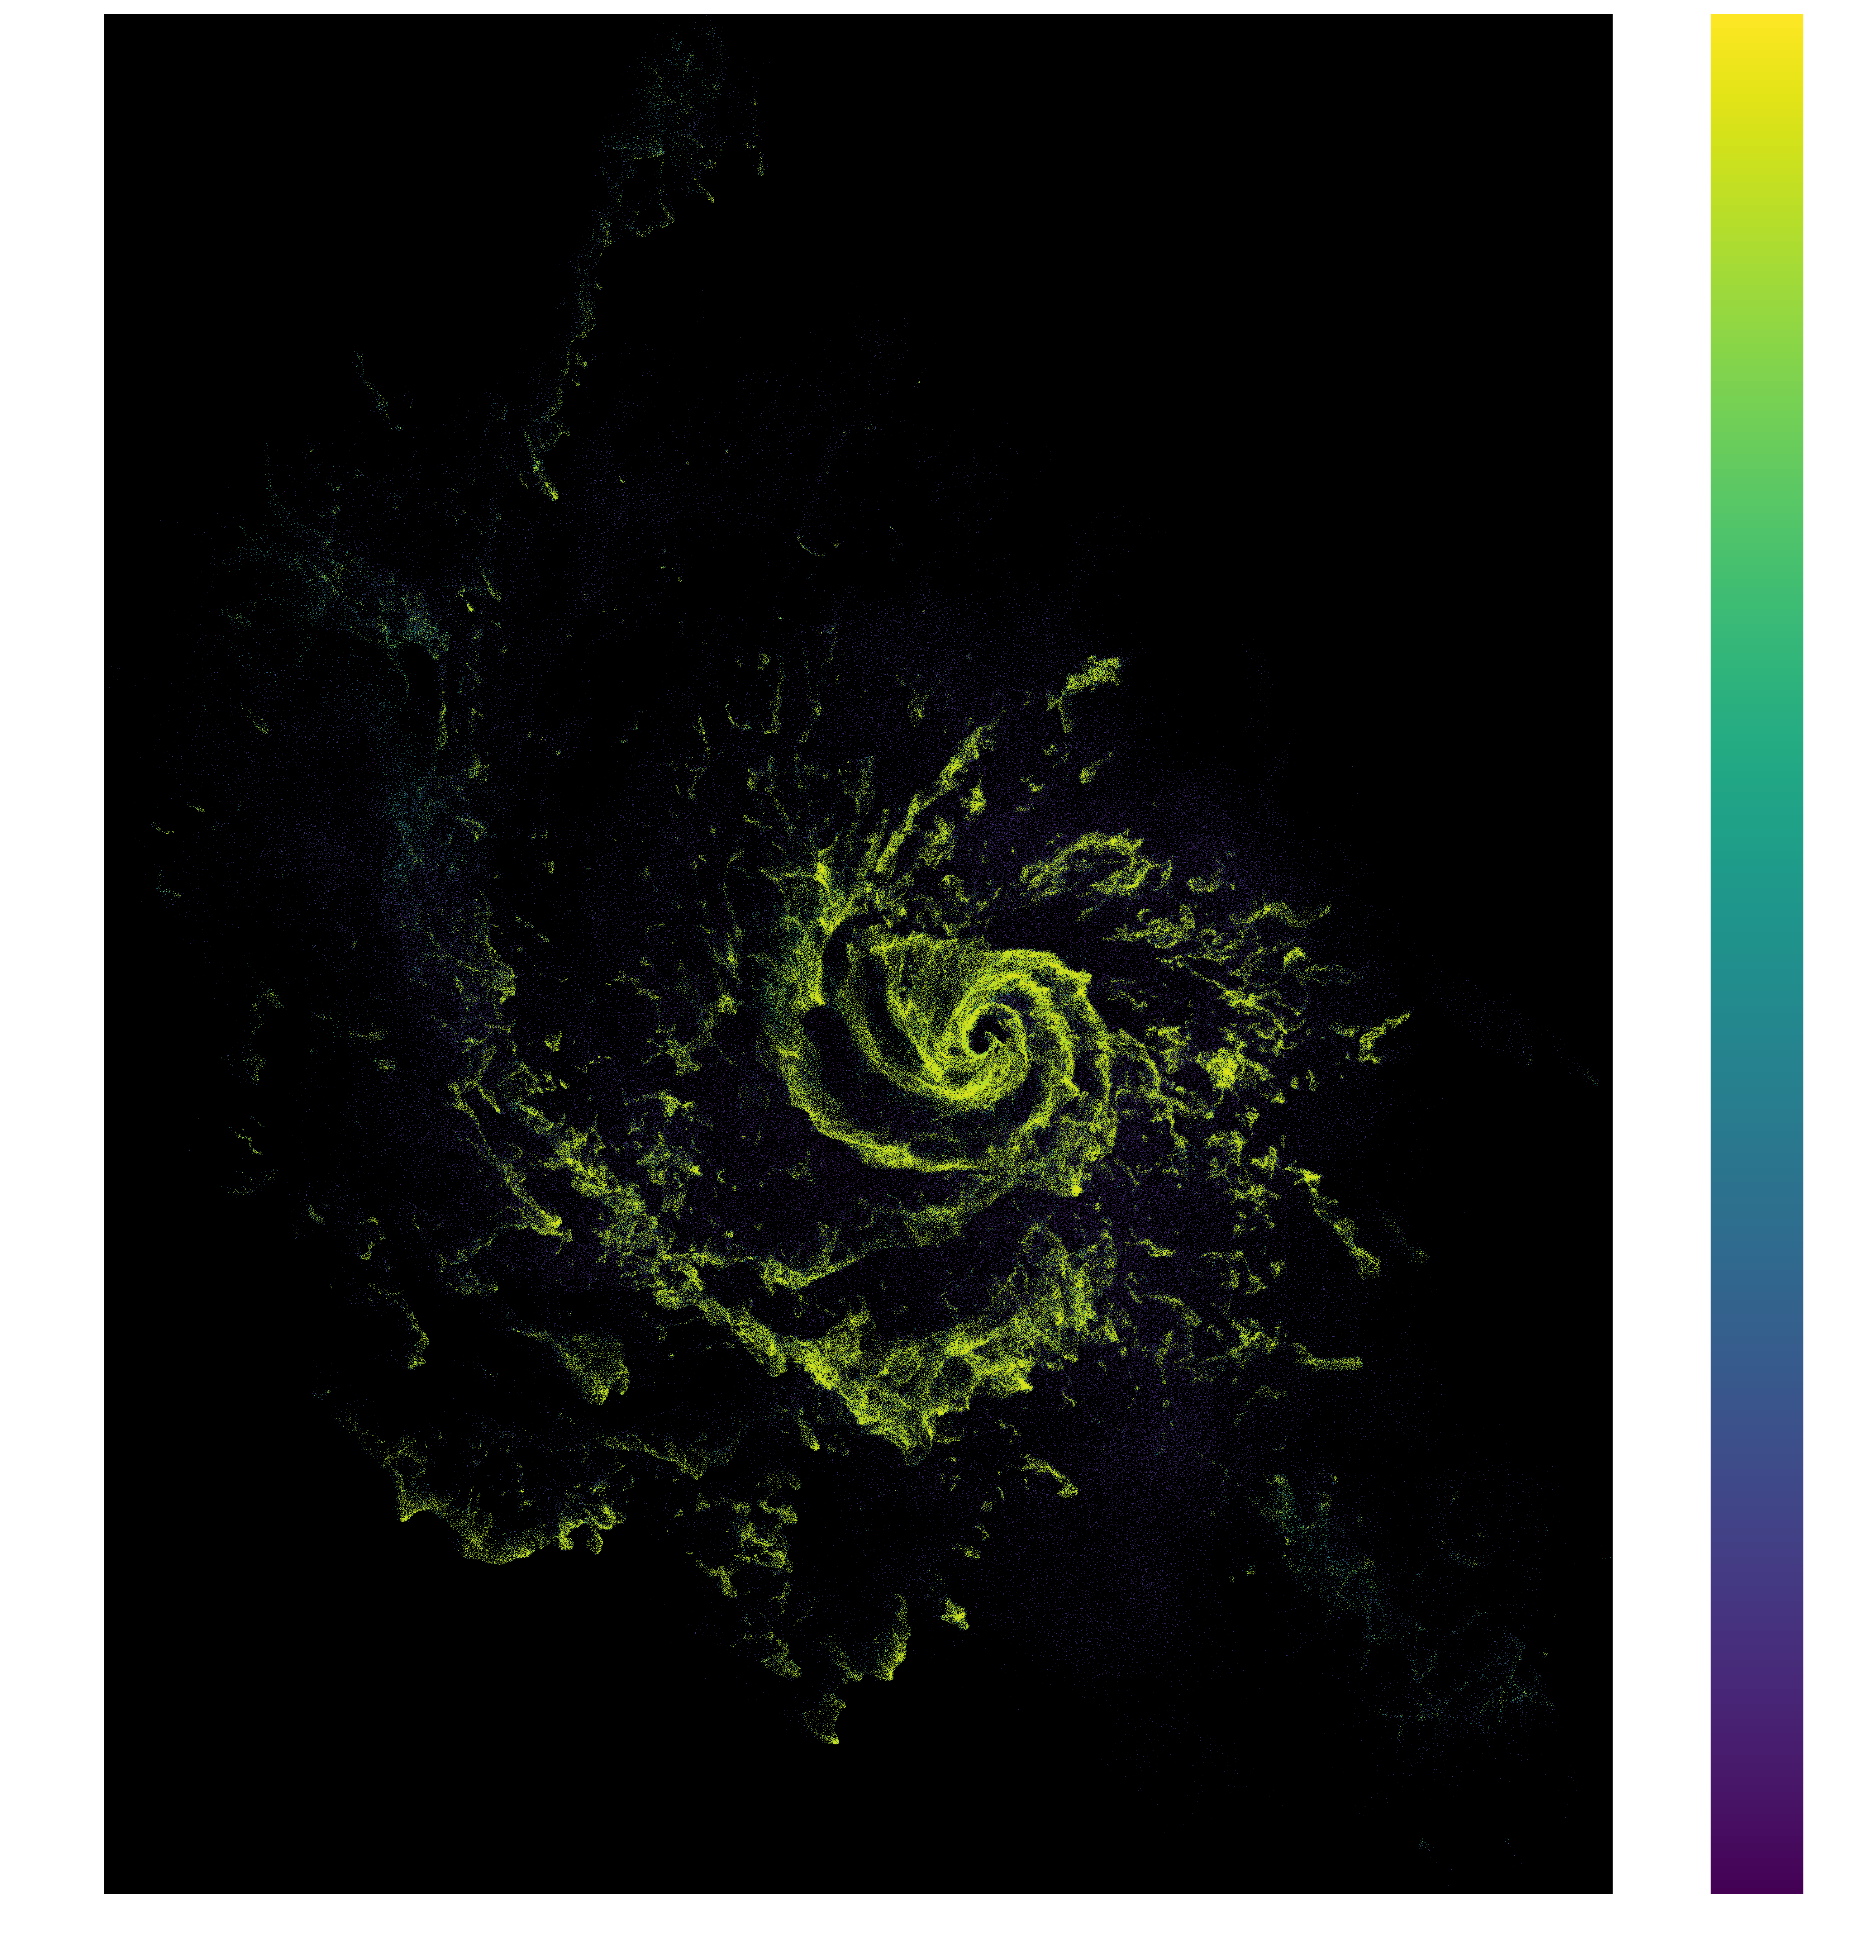

In [2]:
gas_data=il.snapshot.loadSubhalo(basePath, 99, 117251, 'gas', fields=['Coordinates','NeutralHydrogenAbundance','Masses'])

GasCoordinates = gas_data['Coordinates']
GasAbundance = gas_data['NeutralHydrogenAbundance']
Masses = gas_data['Masses']
NeutralHydrogenAbundance=Masses*GasAbundance
    
    
    
GasCoorMin = GasCoordinates.min(axis=0)
GasCoorMax = GasCoordinates.max(axis=0)
plt.figure(figsize=(20, 20), dpi=400)

plt.style.use("dark_background")
bars=10*(GasCoorMax-GasCoorMin)
h, _, _, image = plt.hist2d(GasCoordinates[:, 0],
                            GasCoordinates[:, 2],
                            weights=NeutralHydrogenAbundance,
                            
                            norm=mpl.colors.LogNorm(),
                            bins=(bars[0],bars[2]))
plt.xlim([GasCoorMin[0],GasCoorMax[0]])
plt.ylim([GasCoorMin[2],GasCoorMax[2]])
plt.xlabel('x [ckpc/h]')
plt.ylabel('z [ckpc/h]')
    #draw_circle = plt.Circle(( CircleCenter[1],  CircleCenter[2]), 150, fill=False)
    #plt.gcf().gca().add_artist(draw_circle)
plt.colorbar(image)
plt.gca().set_aspect(1)
plt.savefig('{}.png'.format(117251))